# Working with text

In this problem, we will load movie reviews from IMDB, a famous movie database and website, and we will try to predict whether the review is positive or negative.

First, the function we will use to diagnose the performance of our model

In [2]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Input data

In [0]:
from keras.datasets import imdb

In [5]:
train, test = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
train_text, train_labels = train
test_text, test_labels = test

In [7]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

In [8]:
train_text.shape

(25000,)

Why are these *texts* numbers?

In [9]:
train_text[4][0:10]  # we show only 10 numbers from this vector for brevity

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637]

In [10]:
max(max(s) for s in train_text)

9999

These are actually indices in a word index

In [11]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [12]:
word_index['car']

516

In [0]:
reversed_word_index = dict((value, key) for (key, value) in word_index.items())

In [0]:
def get_text_from_vector(v):
    return ' '.join(reversed_word_index.get(i-3, '?') for i in v)

In [15]:
get_text_from_vector(train_text[4][0:10])

'? worst mistake of my life br br i picked'

### Prepare data for the network

We need to prepare the data to be an input to the neural network. The input must be a **tensor**. In our case, all vectors should be of the same length. But not all reviews are of the same size, so the vectors will have different sizes. How can we overcome this problem?

* We can zero-pad the vectors, so all of them have the same size, and then combine them in a tensor. We would need to add an *Embedding* layer to learn **word embeddings** (more later)
* Or we can use 1-HOT encoding

In both cases, we will have vectors of size $10^4$ (the maximum number of words). Let's go with the 1-HOT encoding.

In [0]:
from keras.preprocessing.text import Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=10000)

In [0]:
x_train = tokenizer.sequences_to_matrix(train_text, mode='binary')

In [19]:
x_train.shape  # 25k rows, one per review;  and 10k columns, one per word. Cells will be 1 or 0

(25000, 10000)

In [20]:
x_train[0:5,0:7]  # excerpt from the matrix

array([[0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 0., 1.],
       [0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1.]])

In [0]:
x_test = tokenizer.sequences_to_matrix(test_text, mode='binary')

**EXERCISE 1**. Can you see any problem with this approach? How would you solve it?

**EXERCISE 2**. Do we need to transform the labels? Why? Or why not?

## Let's build the model

In [0]:
from keras import layers
from keras import models

In [0]:
def build_model():
    m = models.Sequential()
    m.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
    #m.add(layers.Dense(64, activation='relu'))
    #m.add(layers.Dense(32, activation='relu'))
    m.add(layers.Dense(16, activation='relu'))
    m.add(layers.Dense(1, activation='sigmoid'))
    return m

In [0]:
from keras import optimizers
from keras import losses
from keras import metrics

In [0]:
m = build_model()

In [26]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,282,209
Trainable params: 1,282,209
Non-trainable params: 0
_________________________________________________________________


In [0]:
m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

In [28]:
h = m.fit(x_train, train_labels, epochs=20, batch_size=1024, validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 116us/step - loss: 0.5453 - binary_accuracy: 0.7110 - val_loss: 0.4012 - val_binary_accuracy: 0.8388
Epoch 2/20
20000/20000 [==============================] - 1s 71us/step - loss: 0.3113 - binary_accuracy: 0.8811 - val_loss: 0.3083 - val_binary_accuracy: 0.8810
Epoch 3/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.2278 - binary_accuracy: 0.9167 - val_loss: 0.3016 - val_binary_accuracy: 0.8824
Epoch 4/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.1841 - binary_accuracy: 0.9299 - val_loss: 0.3903 - val_binary_accuracy: 0.8506
Epoch 5/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.1713 - binary_accuracy: 0.9358 - val_loss: 0.2751 - val_binary_accuracy: 0.8934
Epoch 6/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.1174 - binary_accuracy: 0.9622 - val_loss: 0.3755 - val_binary_a

20000/20000 [==============================] - 1s 69us/step - loss: 0.0888 - binary_accuracy: 0.9689 - val_loss: 0.3238 - val_binary_accuracy: 0.8868
Epoch 9/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.0802 - binary_accuracy: 0.9734 - val_loss: 0.3348 - val_binary_accuracy: 0.8854
Epoch 10/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.0355 - binary_accuracy: 0.9931 - val_loss: 0.4428 - val_binary_accuracy: 0.8692
Epoch 11/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.0519 - binary_accuracy: 0.9831 - val_loss: 0.3917 - val_binary_accuracy: 0.8812
Epoch 12/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.0582 - binary_accuracy: 0.9804 - val_loss: 0.3827 - val_binary_accuracy: 0.8840
Epoch 13/20
20000/20000 [==============================] - 1s 67us/step - loss: 0.0144 - binary_accuracy: 0.9986 - val_loss: 0.4315 - val_binary_accuracy: 0.8816
Epoch 14/20
20000/20000 [================

20000/20000 [==============================] - 1s 70us/step - loss: 0.0222 - binary_accuracy: 0.9933 - val_loss: 0.4723 - val_binary_accuracy: 0.8806
Epoch 16/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.0056 - binary_accuracy: 0.9997 - val_loss: 0.5063 - val_binary_accuracy: 0.8782
Epoch 17/20
20000/20000 [==============================] - 1s 69us/step - loss: 0.0258 - binary_accuracy: 0.9934 - val_loss: 0.7794 - val_binary_accuracy: 0.8414
Epoch 18/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.0066 - binary_accuracy: 0.9986 - val_loss: 0.5429 - val_binary_accuracy: 0.8772
Epoch 19/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.0023 - binary_accuracy: 0.9998 - val_loss: 0.5752 - val_binary_accuracy: 0.8780
Epoch 20/20
20000/20000 [==============================] - 1s 70us/step - loss: 0.0016 - binary_accuracy: 1.0000 - val_loss: 0.6103 - val_binary_accuracy: 0.8750


# Analyze performance

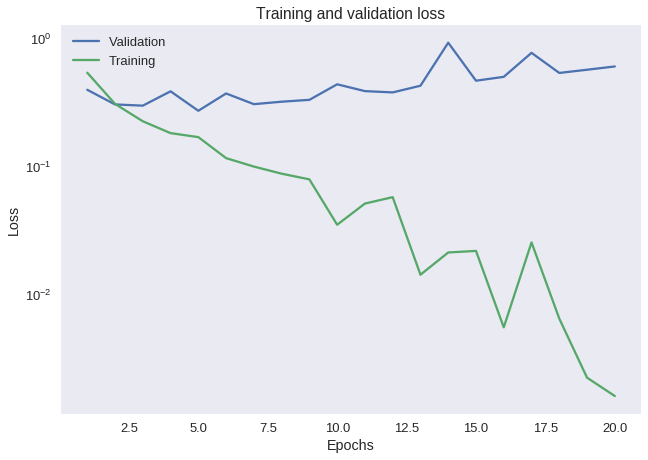

In [29]:
plot_metric(h, 'loss')

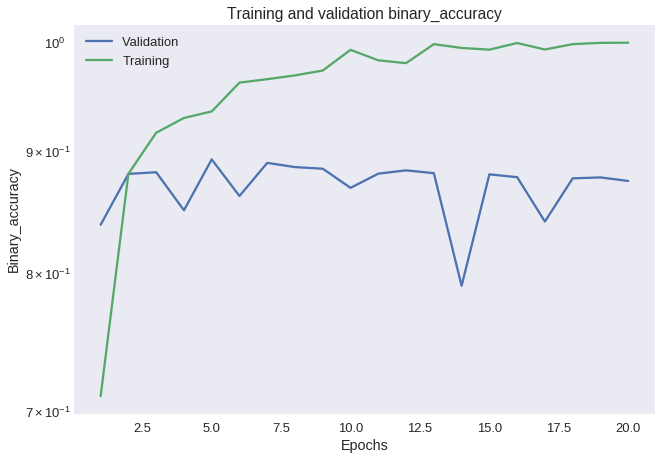

In [31]:
plot_metric(h, 'binary_accuracy')

We cannot find a satisfactory model with what we have learned so far. Is there any way to have a better representation of text that can provide better results?

In [32]:
m.evaluate(x_test, test_labels)

25000/25000 [==============================] - 3s 126us/step


[0.6394380159911514, 0.8654]

# Word embeddings

Using 1-HOT encoded vectors produce large and sparse tensors, that are difficult to learn from using a neural network. Word embeddings are compact vectors, representing words in a vector space. These vectors are learnt in a neural network, with a layer of type *Embedding*. We can also even use pre-trained word embeddings, to improve our model

![](./imgs/07_embeddings.png)

To generate  an embedding, we need to tokenize the text, transforming words into indices, and then we use these lists of numbers to produce the vectorial representation:

![](./imgs/08_embeddings.png)

More info:
* http://www.offconvex.org/2015/12/12/word-embeddings-1/
* http://www.offconvex.org/2016/02/14/word-embeddings-2/

## Input data for word embeddings

In [0]:
max_words = 10000
max_len = 100  # maximum length of the reviews
embedding_dim = 32  # number of components of the embedding vector

In [0]:
from keras import preprocessing

In [0]:
x_train = preprocessing.sequence.pad_sequences(train_text, maxlen=max_len)

In [36]:
x_train.shape

(25000, 100)

In [37]:
x_train[0:5, 0:10]  # we are limiting the reviews to just 100 words, with a vocabulary of 10ˆ4 words

array([[1415,   33,    6,   22,   12,  215,   28,   77,   52,    5],
       [ 163,   11, 3215,    2,    4, 1153,    9,  194,  775,    7],
       [1301,    4, 1873,   33,   89,   78,   12,   66,   16,    4],
       [  40,    2,   13,  188, 1076, 3222,   19,    4,    2,    7],
       [  13,   16,  131, 2073,  249,  114,  249,  229,  249,   20]],
      dtype=int32)

In [0]:
x_test = preprocessing.sequence.pad_sequences(test_text, maxlen=max_len)

## Let's build the model with embeddings

In [0]:
# Try first with Dense layers,
# Then SimpleRNN without return_sequences
# Then with return_sequences
# Then several RNN layers
# Then show LSTM layers
def build_model():
    m = models.Sequential()
    m.add(layers.Embedding(max_words, embedding_dim))
    #m.add(layers.Dense(32, activation='relu'))
    #m.add(layers.SimpleRNN(32, return_sequences=True))        
    #m.add(layers.SimpleRNN(32, return_sequences=True))
    #m.add(layers.SimpleRNN(32, return_sequences=True))
    #m.add(layers.SimpleRNN(32, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    #m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(32))
    m.add(layers.Dense(1, activation='sigmoid'))
    return m

In [0]:
m = build_model()

In [41]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [0]:
m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

In [44]:
h = m.fit(x_train, train_labels, epochs=10, batch_size=512, validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.5830 - binary_accuracy: 0.6748 - val_loss: 0.4532 - val_binary_accuracy: 0.7846
Epoch 2/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.3769 - binary_accuracy: 0.8345 - val_loss: 0.4768 - val_binary_accuracy: 0.7674
Epoch 3/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3121 - binary_accuracy: 0.8740 - val_loss: 0.4649 - val_binary_accuracy: 0.7788
Epoch 4/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2644 - binary_accuracy: 0.8972 - val_loss: 0.5211 - val_binary_accuracy: 0.8136
Epoch 5/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2328 - binary_accuracy: 0.9134 - val_loss: 0.4052 - val_binary_accuracy: 0.8356
Epoch 6/10
  512/20000 [..............................] - ETA: 24s - loss: 0.1264 - binary_accuracy: 0.9570

20000/20000 [==============================] - 26s 1ms/step - loss: 0.2154 - binary_accuracy: 0.9170 - val_loss: 0.4023 - val_binary_accuracy: 0.8376
Epoch 7/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1949 - binary_accuracy: 0.9265 - val_loss: 0.6465 - val_binary_accuracy: 0.7500
Epoch 8/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1808 - binary_accuracy: 0.9330 - val_loss: 0.5116 - val_binary_accuracy: 0.8220
Epoch 9/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1700 - binary_accuracy: 0.9376 - val_loss: 0.4142 - val_binary_accuracy: 0.8342
Epoch 10/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1502 - binary_accuracy: 0.9460 - val_loss: 0.4365 - val_binary_accuracy: 0.8324


## Analyze performance

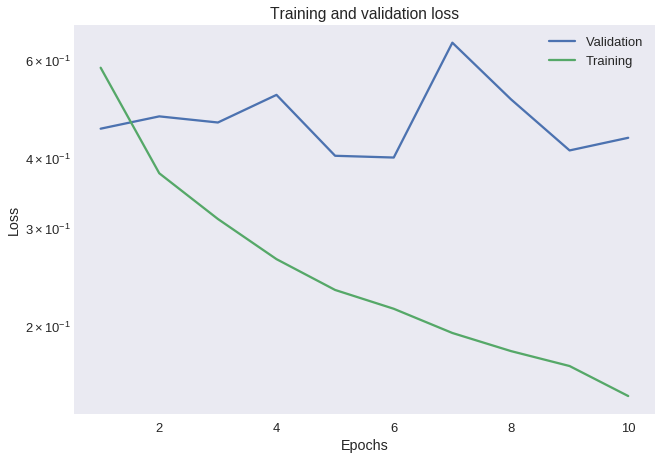

In [45]:
plot_metric(h, 'loss')

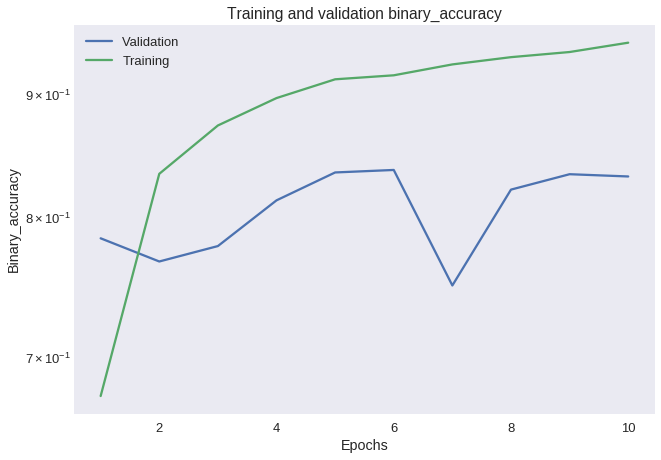

In [46]:
plot_metric(h, 'binary_accuracy')

Not bad, with just an embedding layer, we get $75\%$ accuracy

In [48]:
loss, acc = m.evaluate(x_test, test_labels, batch_size=512)

25000/25000 [==============================] - 6s 254us/step


In [49]:
loss, acc

(0.4539614862728119, 0.8280400000572204)

How many reviews will be misclassified?

In [50]:
(1-acc)*len(test_labels)

4298.9999985694885

Let's check some of the predictions

In [0]:
# N = 123
N = 2344

In [56]:
m.predict(x_test[N:N+1,])[0][0] >= 0.5

False

In [57]:
test_labels[N]

0

So this prediction is correct. It says the review is negative. Let's have a look at the text:

In [58]:
get_text_from_vector(test_text[N])

"? there is a reason ? of the board got a 2 which is too high this movie flat out is one of the worse movies of all time and i seen my share of rotten films ? of the board stars two of the most annoying actors people today ? top and ? ? smith ? top just isn't funny anymore and wasn't in this piece of trash ? ? smith isn't any better just watch according to jim and you will see a prime example of what i am talking about ? of the board got a 1 from me because that is low as you can go it is that bad i am a little shocked that this piece of junk isn't on the imdb bottom 100 somewhere i would put this in the top 5 on that list but its slowly working its way there"

Can we find all the reviews that are wrongly classified?

In [62]:
preds = m.predict(x_test)

KeyboardInterrupt: ignored

In [63]:
preds.shape

(25000, 1)

In [64]:
preds[0:10]

array([[0.04352121],
       [0.99306023],
       [0.97097373],
       [0.17259781],
       [0.9961451 ],
       [0.66163945],
       [0.98867995],
       [0.00935475],
       [0.93871427],
       [0.9929426 ]], dtype=float32)

In [0]:
preds_binary = (preds >= 0.5).reshape((len(preds),))

In [66]:
preds_binary.shape

(25000,)

In [67]:
test_labels.shape

(25000,)

In [0]:
wrong_pos = np.where(test_labels != preds_binary)[0]
ok_pos = np.where(test_labels == preds_binary)[0]

In [102]:
wrong_pos.shape, ok_pos.shape

((4299,), (20701,))

In [70]:
wrong_pos[0:100]

array([  8,  38,  45,  49,  55,  59,  66,  75,  77,  80,  93,  95,  98,
       101, 112, 113, 115, 126, 146, 152, 154, 156, 159, 167, 174, 176,
       182, 191, 203, 205, 227, 232, 247, 248, 256, 257, 259, 267, 274,
       282, 283, 296, 298, 299, 300, 302, 310, 322, 333, 339, 342, 345,
       348, 349, 352, 355, 358, 363, 367, 376, 378, 384, 386, 399, 414,
       415, 416, 433, 434, 438, 449, 455, 488, 491, 495, 498, 503, 516,
       517, 531, 537, 544, 547, 548, 549, 550, 556, 558, 562, 570, 573,
       581, 593, 598, 612, 614, 629, 634, 641, 653])

In [71]:
preds_binary[3], preds[3][0]

(False, 0.17259781)

In [72]:
test_labels[3]

0

In [73]:
get_text_from_vector(test_text[3])

"? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision"

Is the classifier symmetric?

In [0]:
fp_pos = wrong_pos[test_labels[wrong_pos] == 0]

In [75]:
fp_pos.shape

(2144,)

In [0]:
fn_pos = wrong_pos[test_labels[wrong_pos] == 1]

In [77]:
fn_pos.shape

(2155,)

<Container object of 2 artists>

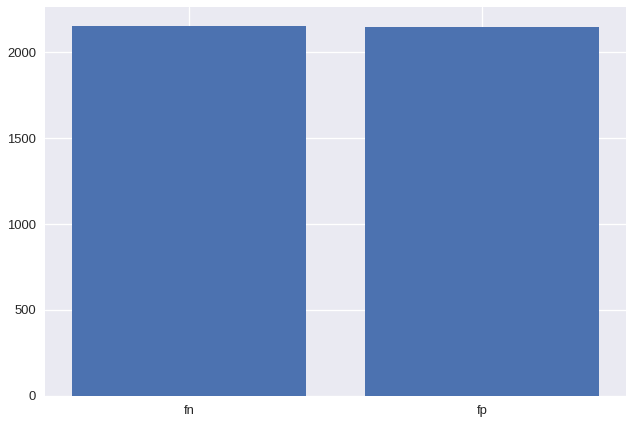

In [78]:
plt.bar(['fp','fn'],[fp_pos.shape[0],fn_pos.shape[0]])

**EXERCISE** Can you construct the confusion matrix for this model? Can you calculate the precision and recall? How does it compare to accuracy?
* See https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

**EXERCISE (more complex)** Keras decided some time ago to remove precision, recall and F1-score from the list of available metrics. Was it a good decision? Why? Why did the Keras' authors did not remove accuracy too?
* https://github.com/keras-team/keras/issues/5794
* https://github.com/keras-team/keras/issues/4592

**EXERCISE** What is the ROC curve? Could you build the ROC curve for this model? How would you use a ROC curve to evaluate a classifier?
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* Help: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [0]:
from sklearn import metrics

In [0]:
roc = metrics.roc_curve(test_labels, preds)

In [81]:
roc

(array([0.0000e+00, 0.0000e+00, 8.0000e-05, ..., 9.9864e-01, 9.9880e-01,
        1.0000e+00]),
 array([8.0e-05, 9.6e-04, 9.6e-04, ..., 1.0e+00, 1.0e+00, 1.0e+00]),
 array([0.997586  , 0.9973013 , 0.99729127, ..., 0.00288693, 0.00285966,
        0.00257292], dtype=float32))

In [0]:
auc = metrics.roc_auc_score(test_labels, preds)

In [83]:
auc

0.9092966175999999

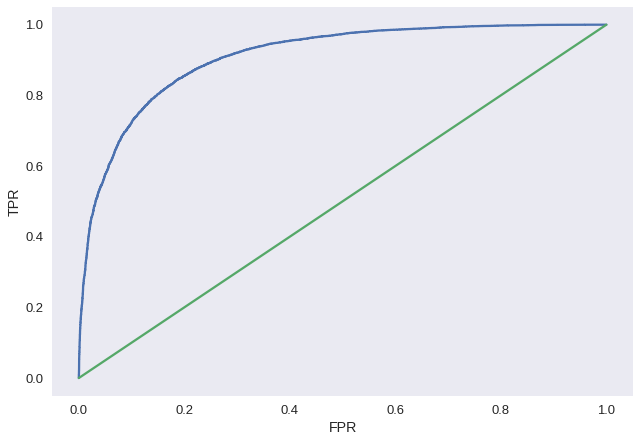

In [84]:
fpr, tpr, _ = roc
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1],'-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

Let's analyze wrong positives and wrong negatives separately. Then we will try to find a relationship between the words and the misclassification, both for false positives and negatives.

In [85]:
fp_pos.shape

(2144,)

In [0]:
def words_hist(pos, texts):
    words_hist = {}

    for p in pos:
        ws = get_text_from_vector(texts[p]).split(' ')
        for w in ws:
            if w in words_hist.keys():
                words_hist[w] += 1
            else:
                words_hist[w] = 1
        
    return words_hist

In [0]:
fp_words = words_hist(fp_pos, test_text)

Now let's compare with the words of the true positives

In [0]:
tp_pos = ok_pos[test_labels[ok_pos] == 1]

In [104]:
tp_pos.shape

(10345,)

In [0]:
tp_words = words_hist(tp_pos, test_text)

In [0]:
import pandas as pd

In [0]:
fp_df = pd.DataFrame.from_dict(fp_words, orient='index')
tp_df = pd.DataFrame.from_dict(tp_words, orient='index')

In [108]:
fp_df.head()

,0
?,32429
hollywood,155
had,996
a,15237
long,300


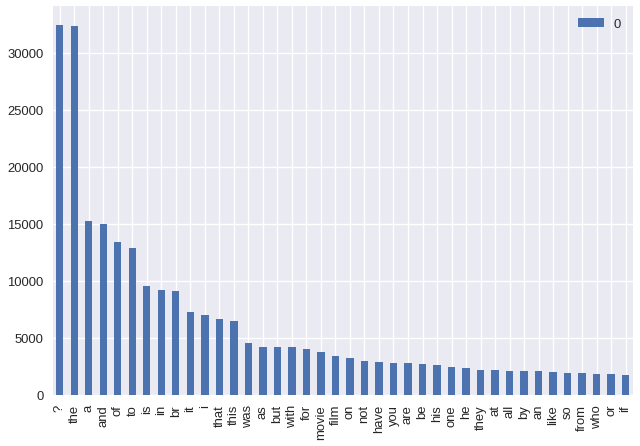

In [109]:
fp_df.sort_values(by=0, ascending=False)[0:40].plot.bar()

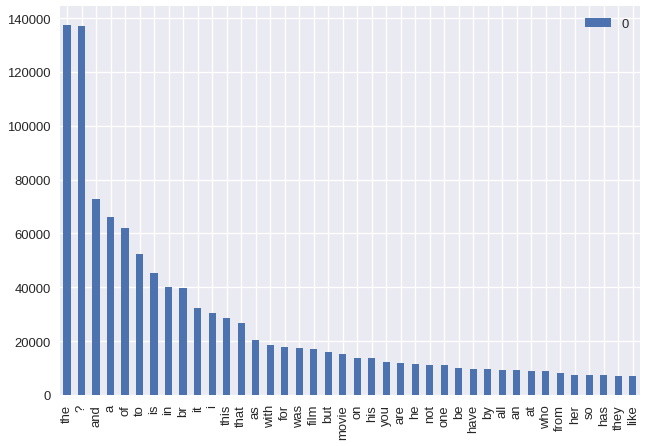

In [110]:
tp_df.sort_values(by=0, ascending=False)[0:40].plot.bar()

So the most common words are very similar. Not surprising. Let's calculate the relative frequency of each word, and then find what are the words with the highest difference in relative frequency.

In [0]:
tp_df['f'] = tp_df[0]/tp_df[0].sum()*100
fp_df['f'] = fp_df[0]/fp_df[0].sum()*100

In [112]:
fp_df.head()

,0,f
?,32429,5.857279
hollywood,155,0.027996
had,996,0.179896
a,15237,2.752085
long,300,0.054186


In [113]:
tp_df.head()

,0,f
?,136960,5.792098
this,28567,1.208111
film,17124,0.724181
requires,55,0.002326
a,65970,2.789900


In [0]:
diffs = tp_df-fp_df

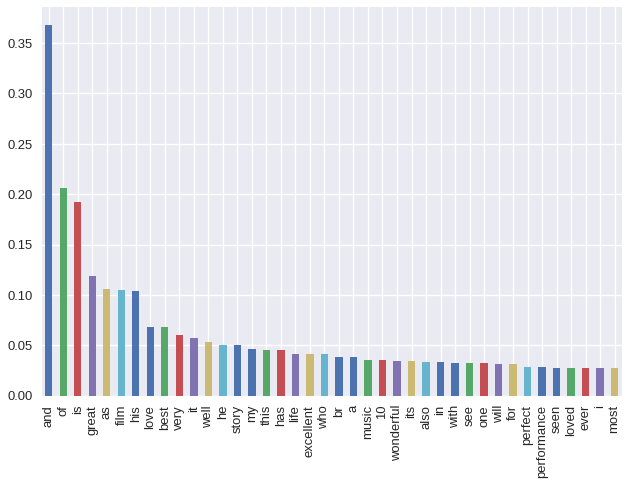

In [115]:
diffs.sort_values(by='f', ascending=False)[0:40]['f'].plot.bar()

We see words such as *great*, *best*, *excellent*, which have a large difference between the true and the false positives. So false positives seem to lack some extreme words, and the classifier is having a hard time trying to assign a category to those reviews.